In [1]:
# %pip install --upgrade pip --user
# %pip install zarr --user
# %pip install tables --user
# %pip install git+https://github.com/simpeg/simpeg.git@simulation-tdem --user
# %pip install dask dask_jobqueue --user
# %pip install git+https://github.com/simpeg-research/casingSimulations.git@simulation --user

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import discretize
from discretize.utils import mkvc
from scipy import sparse as sp
from scipy.constants import mu_0
from SimPEG.utils.SolverUtils import SolverWrapI
import pandas as pd
from pymatsolver import Pardiso, SolverCG
import os
import json
import ipywidgets

import casingSimulations as casing_sim

from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import (
    props, maps, data, data_misfit, regularization, optimization, 
    inversion, inverse_problem, survey, directives
)

%matplotlib inline

In [3]:
Solver = Pardiso
solver_opts = {} #{"maxiter": 10}

In [4]:
data_directory = "./experiment1"
df = pd.read_hdf(f"{data_directory}/trial_data.h5", "data")

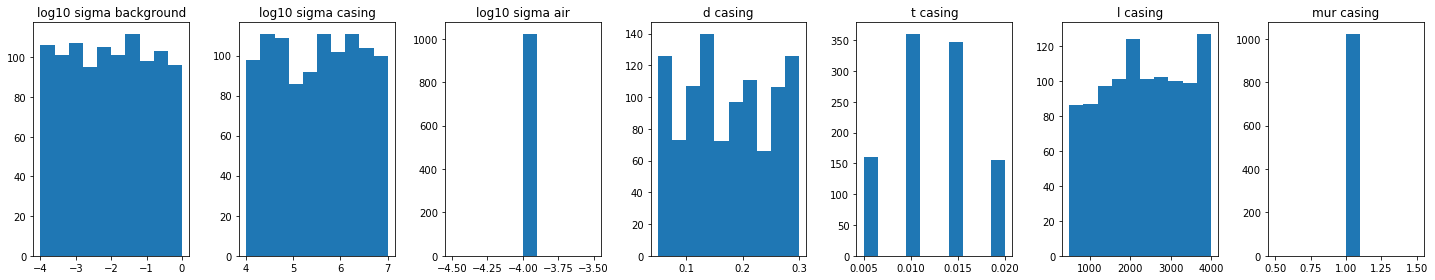

In [5]:
fig, ax = plt.subplots(1,len(df.keys()), figsize=(20, 4))

for i, key in enumerate(df.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [6]:
# pick a single model to try training on 
trial_index = 5  # a 1200 m long well (relatively short --> fast simulations)

trial_directory = f"{data_directory}/trial_{trial_index}"

In [7]:
# generate the 2D model 

with open(f"{trial_directory}/approx_casing.json") as f: 
    params = json.load(f)
model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

with open(f"{trial_directory}/simulation_approx_casing.json") as f:
    simulation_params = json.load(f)
    
sim3D = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
mesh3D = sim3D.mesh

In [8]:
print(model)


 ---- Survey ---- 


 ---- Model ---- 

  background: 
    - conductivity: 1.5e-02 S/m
    - permeability: 1.0 mu_0

  air: 
    - conductivity: 1.0e-04 S/m
    - earth surface elevaation: 0.0 m


 ---- Casing ---- 

  properties: 
    - conductivity: 3.4e+06 S/m
    - permeability: 1.0 mu_0
    - conductivity inside: 3.4e+06 S/m

  geometry: 
    - casing top: 0.0 m
    - casing length: 1200.0 m
    - casing diameter: 6.0e-02 m
    - casing thickness: 2.0e-02 m


In [9]:
# create a 2D simulation
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))


(-2000, 10)

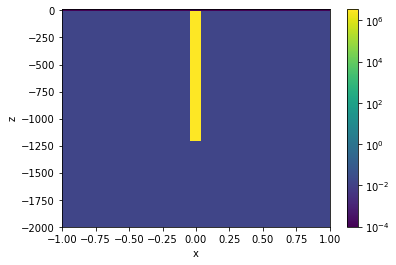

In [10]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    mesh.plotImage(
        sim.sigma, ax=ax, pcolorOpts={"norm":LogNorm()}, mirror=True
    )[0], ax=ax
)
ax.set_xlim([-1, 1])
ax.set_ylim([-2000, 10])

In [11]:
def load_trial(trial_directory):
    
    # model parameters
    with open(f"{trial_directory}/casing.json") as f: 
        params = json.load(f)
    casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)
    
    with open(f"{trial_directory}/approx_casing.json") as f: 
        params = json.load(f)
    approx_casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

    model_dict = {
        "casing": casing, 
        "approx_casing": approx_casing
    }
    
    with open(f"{trial_directory}/simulation_approx_casing.json") as f:
        simulation_params = json.load(f)

    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    sim.survey.source_list = sim.survey.source_list # HAck to trigger the validator 
    mesh = sim.mesh
    
    # load up the fields
    fields_dict = {}
    for key in model_dict.keys():
        print(key)
        sim.sigma = model_dict[key].sigma(mesh)
        f = np.load(f"{trial_directory}/{key}_fields.npy")
        fields_dict[key] = sim.fieldsPair(sim)
        fields_dict[key][:, "jSolution", :] = f
    
    return model_dict, fields_dict, sim, mesh 

In [12]:
def get_j_inds(
    mesh, nT, x_bounds=np.r_[1, 2000], z_bounds=np.r_[-2000, 0],
):
  
    inds_Fx = (
        (mesh.gridFx[:, 0] > x_bounds.min()) & (mesh.gridFx[:, 0] < x_bounds.max()) &
        (mesh.gridFx[:, 2] > z_bounds.min()) & (mesh.gridFx[:, 2] < z_bounds.max()) 
    )
    
    inds_Fx = np.kron(np.ones(sim.nT+1, dtype=bool), inds_Fx)
    
    inds_Fz = (
        (mesh.gridFz[:, 0] > x_bounds.min()) & (mesh.gridFz[:, 0] < x_bounds.max()) &
        (mesh.gridFz[:, 2] > z_bounds.min()) & (mesh.gridFz[:, 2] < z_bounds.max()) 
    )
    inds_Fz = np.kron(np.ones(nT+1, dtype=bool), inds_Fz)
    
    inds = np.hstack([inds_Fx, inds_Fz])

    return inds
    

# set up a simple test example 

In [15]:
def waveform(t, t_peak=2e-3, width=20, amplitude=1):
    t = np.log10(t)
    t_peak = np.log10(t_peak)
    width = np.log10(width)
    return amplitude * np.exp(-(t - t_peak)**2/(2*width**2))

def sigmoid(x, x0=0, slope=1):
    return np.arctan(slope * (x-x0))/np.pi + 0.5

def depth_distribution(z, t, dz=200, slope=1e-1):
    Z = np.outer(z, np.ones(len(t)))
    top = model.casing_z.max()
    time_fact = -np.log(t + t[1])
    time_fact = -10*(t)/np.max(t)
    T = np.outer(np.ones(len(z)), time_fact)
    bottom = -(model.casing_z.min()*T)-dz 
    return sigmoid(Z, bottom, slope) * sigmoid(-Z, -top, slope)

def source_se(mesh, t, z, dz=200, slope=None):
    sm = np.zeros(mesh.nE)
    wave = np.outer(np.ones(len(z)), waveform(t))
    sm = depth_distribution(z, t, dz=dz, slope=slope) * waveform(t)
    
    return sm

In [16]:
# z = np.load(f"{trial_directory}/z_currents.npy")
csx = mesh.hx.min()

# xinds = (mesh.gridFz[:, 0] < model.casing_b + csx/2) & (mesh.gridFz[:, 0] > model.casing_b - csx/2)

# # xinds = (mesh.gridFz[:, 0] < model.casing_b/2 + csx/2) & (mesh.gridFz[:, 0] > model.casing_b/2 - csx/2)
# zinds = (mesh.gridFz[:, 2] >= model.casing_z.min()) & (mesh.gridFz[:, 2] <= model.casing_z.max())
# src_inds_bool = xinds & zinds
# src_inds = np.where(src_inds_bool)[0]
# z = mesh.gridFz[src_inds, 2]

# print(np.unique(mesh.gridFz[xinds, 0]))

In [17]:
z = mesh.vectorNz[(mesh.vectorNz >= model.casing_z.min()) & (mesh.vectorNz <= model.casing_z.max())]
src_vec = -1*source_se(mesh, sim.times, z, dz=300, slope=1e-2)

-12300.0 -300.0


//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'z')

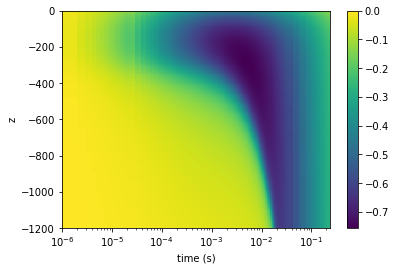

In [18]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.pcolormesh(sim.times, z, src_vec), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [19]:
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))

In [23]:
class SourceMap(maps.IdentityMap):
    def __init__(self, mesh, spatial_index, nT):
        spatial_inds = np.zeros(mesh.nF, dtype=bool)
        spatial_inds[spatial_index] = True
        time_index = np.ones(nT, dtype=bool)
        index = np.kron(time_index, spatial_inds)
        
        super(SourceMap, self).__init__(mesh=mesh, nP=index.sum())
        self.index = index
        self.nF = self.mesh.nF
        self.nT = nT
    
    def _transform(self, m):
        src = np.zeros(self.nF*self.nT)
        src[self.index] = m
        return src
    
    def deriv(self, m, v=None):
        if v is None:
            P = sp.csr_matrix(
                (np.ones(self.nP), (self.index.nonzero()[0], range(self.nP))), 
                shape=(self.nF*self.nT, self.nP)
            )
            return P
        return self._transform(v)
                  

In [33]:
# xinds = (mesh.gridFz[:, 0] < model.casing_b + csx/2) & (mesh.gridFz[:, 0] > model.casing_b - csx/2)

xinds = (mesh.gridFz[:, 0] < csx) #& (mesh.gridFz[:, 0] > model.casing_b/2 - csx/2)
zinds = (mesh.gridFz[:, 2] >= model.casing_z.min()) & (mesh.gridFz[:, 2] <= model.casing_z.max())
src_inds_bool = xinds & zinds
src_inds = np.where(src_inds_bool)[0]
src_inds = src_inds + mesh.nFx

# z = mesh.gridFz[src_inds, 2]

In [34]:
src_map = SourceMap(mesh, src_inds, sim.nT+1)
# src_map * discretize.utils.mkvc(src_vec)
src_map.test(discretize.utils.mkvc(src_vec))

Testing SourceMap(15228,46031)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.140e+01     4.329e-15      nan
 1   1.00e-02    2.140e+00     4.223e-15      0.011
 2   1.00e-03    2.140e-01     4.210e-15      0.001
 3   1.00e-04    2.140e-02     4.208e-15      0.000
========================= PASS! =========================
Yay passed!



True

In [35]:
# fig, ax = plt.subplots(1, 1)
# tind = 40
# plotme = (src_map * discretize.utils.mkvc(src_vec)).reshape((mesh.nEy, sim.nT+1), order="F")[:, tind]

# plt.colorbar(
#     mesh.plotImage(
#         mesh.aveEy2CC * plotme, ax=ax, mirror=True, 
#         pcolorOpts={"cmap":"BrBG_r"}, clim=plotme.max()*np.r_[-1, 1]
#     )[0], ax=ax
# )
# ax.set_xlim(0.2*np.r_[-1, 1])
# ax.set_ylim([-2000, 10])

In [73]:
class MySimulation(tdem.Problem3D_j):
    
    source, source_map, source_deriv = props.Invertible("source term")
    
    j_inds = None
    
    survey = None
    
    def fields(self, m):
        self.model = m
        
#         source = self.source.reshape(sim.mesh.nEy, sim.nT+1, order="F")
        f = np.zeros((self.mesh.nF, self.nT+1))

        # this assumes the initial condition is zero. 

        # timestep to solve forward
        Ainv = None
        
        for tInd, dt in enumerate(self.timeSteps):
            # keep factors if dt is the same as previous step b/c A will be the
            # same
            if Ainv is not None and (
                tInd > 0 and abs(dt-self.timeSteps[tInd - 1]) >
                self.dt_threshold
            ):
                Ainv.clean()
                Ainv = None

            if Ainv is None:
                A = self.getAdiag(tInd)
                Ainv = self.solver(A)

            rhs = self.getRHS(tInd+1)  # this is on the nodes of the time mesh
            Asubdiag = self.getAsubdiag(tInd)

            # taking a step
            sol = Ainv * (rhs - Asubdiag * f[:, tInd])
            f[:, tInd+1] = sol

        # clean factors and return
        Ainv.clean()
        return f

    def dpred(self, m, f=None):
        if f is None: 
            f = self.fields(m)
        return mkvc(f)[self.j_inds]

    def getRHS(self, tInd):
        src = self.source.reshape((self.mesh.nF, self.nT+1), order="F")
        rhs = -1/self.time_steps[tInd-1] * (src[:, tInd] - src[:, tInd-1])
        if self._makeASymmetric:
            return self.MfRho.T * rhs
        return rhs

    def getRHSDeriv(self, tInd, v, adjoint=False):

        if adjoint:
            if self._makeASymmetric:
                v = self.MfRho * v
            else:
                v = v 
            
            rhs = np.zeros((self.mesh.nF, self.nT+1))
            rhs[:, tInd] = v
            rhs[:, tInd-1] = -v
            return -1/self.time_steps[tInd-1] * rhs

        v = v.reshape((self.mesh.nF, self.nT+1), order="F")
        rhs = -1/self.time_steps[tInd-1] * (v[:, tInd] - v[:, tInd-1])

        if self._makeASymmetric:
            return self.MfRho.T * rhs
        return rhs
        
    def Jvec(self, m, v, f=None):
        self.model = m
        v = self.source_deriv * v
#         v = v.reshape((self.mesh.nF, self.nT+1), order="F")
        df_dm_v = np.zeros((self.mesh.nF, self.nT+1))

        # timestep to solve forward
        Ainv = None
        for tInd, dt in enumerate(self.timeSteps):
            # keep factors if dt is the same as previous step b/c A will be the
            # same
            if Ainv is not None and (
                tInd > 0 and abs(dt-self.timeSteps[tInd - 1]) > self.dt_threshold
            ):
                Ainv.clean()
                Ainv = None

            if Ainv is None:
                A = self.getAdiag(tInd)
                Ainv = self.solver(A)

            rhs_deriv = self.getRHSDeriv(tInd+1, v)  # this is on the nodes of the time mesh
            Asubdiag = self.getAsubdiag(tInd)

            # taking a step
            sol = Ainv * (rhs_deriv - Asubdiag * df_dm_v[:, tInd])
            df_dm_v[:, tInd+1] = sol

        # clean factors and return
        Ainv.clean()
        
        return mkvc(df_dm_v)[self.j_inds]
        
    def Jtvec(self, m, v, f=None):
        self.model = m
        if self.j_inds is not None:
            v_tmp = np.zeros(self.mesh.nF*(self.nT+1))
            v_tmp[self.j_inds] = v
            v = v_tmp.reshape(self.mesh.nF, self.nT+1, order="F")
        
        df_dmT_v = np.zeros((self.mesh.nF, self.nT+1))  # the source is defined on faces
        
        # timestep to solve forward
        ATinv = None
        for tInd in reversed(range(self.nT)):
            dt = self.time_steps[tInd]
            # keep factors if dt is the same as previous step b/c A will be the
            # same
            if ATinv is not None and (
                tInd <= self.nT and abs(dt-self.timeSteps[tInd + 1]) > self.dt_threshold
            ):
                ATinv.clean()
                ATinv = None

            if ATinv is None:
                AT = self.getAdiag(tInd).T
                ATinv = self.solver(AT)    

    #         ATinv_v = ATinv * v[:, tInd+1]
            if tInd < self.nT - 1:
                AsubdiagT = self.getAsubdiag(tInd+1).T
                sol = ATinv * (v[:, tInd+1] - AsubdiagT * sol)
            else: 
                sol = ATinv * v[:, tInd+1]
            rhs_deriv = self.getRHSDeriv(tInd+1, sol, adjoint=True)  # this is on the nodes of the time mesh

            df_dmT_v += rhs_deriv

        # clean factors and return
        ATinv.clean()
        return self.source_deriv.T * mkvc(df_dmT_v)

In [74]:
src_map = SourceMap(mesh, src_inds, sim.nT+1)
x_bounds = np.r_[10, 1000]
z_bounds = np.r_[-1200, 0.]
j_inds = get_j_inds(
    mesh, nT=sim.nT, x_bounds=x_bounds, z_bounds=z_bounds
)

mysim = MySimulation(
    mesh=mesh, time_steps=sim3D.time_steps, 
    solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh),
    source_map=src_map, j_inds=j_inds
)

In [75]:
s0 = mkvc(src_vec)

def derChk(m):
    return [mysim.dpred(m), lambda mx: mysim.Jvec(m, mx)]

discretize.Tests.checkDerivative(derChk, s0, plotIt=False, num=3, eps=1e-9)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.048e-07     1.127e-14      nan
 1   1.00e-02    2.048e-08     7.557e-15      0.174
 2   1.00e-03    2.048e-09     9.967e-15      -0.120
========================= PASS! =========================
Go Test Go!



True

In [76]:
v = np.random.rand(len(s0))
w = np.random.rand(j_inds.sum())

wTJv = w.dot(mysim.Jvec(s0, v))
vTJTw = v.dot(mysim.Jtvec(s0, w))

print(f"{wTJv:1.2e}, {vTJTw:1.2e}, {np.abs(wTJv - vTJTw):1.2e}")

-2.31e-05, -2.31e-05, 7.59e-13


# set up an inversion

In [77]:
j_obs = mysim.dpred(s0)

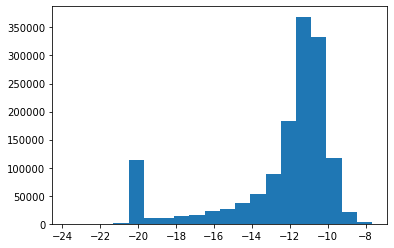

In [78]:
plt.hist(np.log10(np.abs(j_obs+1e-20)), 20);

In [89]:
std = 0.05
floor = 1e-12
mysurvey = survey.BaseSurvey()
mysurvey._vnD = np.r_[len(j_obs)]
mysim.survey = mysurvey
mydata = data.Data(mysurvey, dobs=j_obs, standard_deviation=std, noise_floor=floor)

In [90]:
dmis = data_misfit.L2DataMisfit(data=mydata, simulation=mysim)

In [91]:
dz = np.diff(z)
dz = np.hstack([dz, np.r_[dz[-1]]])

dt = mysim.time_mesh.hx
dt = np.hstack([dt, np.r_[dt[-1]]])

reg_mesh = discretize.TensorMesh([dz, dt], x0=np.r_[z.min(), mysim.times[0]])
reg = regularization.Tikhonov(
    mesh=reg_mesh, 
    alpha_x=dz.mean()**2, # space
    alpha_y=dt.mean()**2, # time
)

In [92]:
opt = optimization.InexactGaussNewton(maxIter=20)
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)

directiveslist = [
    directives.BetaEstimate_ByEig(beta0_ratio=1e2),
    directives.BetaSchedule(),
    directives.TargetMisfit(),
]

inv = inversion.BaseInversion(invprob, directiveList=directiveslist)

In [93]:
print(f"{mysurvey.nD:1.2e}, {0.5*mysurvey.nD:1.2e}")

1.42e+06, 7.09e+05


In [94]:
m0 = 0 * s0 
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/lindseyjh/git/python_symlinks/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.83e+07  5.24e+07  0.00e+00  5.24e+07    4.34e+08      0              
   1  2.83e+07  1.05e+07  1.26e-03  1.06e+07    4.96e+07      0              
   2  2.83e+07  6.71e+06  1.82e-03  6.76e+06    4.43e+07      0              
   3  3.53e+06  4.83e+06  3.18e-03  4.84e+06    5.31e+07      0   Skip BFGS  
   4  3.53e+06  4.23e+06  3.04e-03  4.24e+06    3.39e+07      0              
   5  3.53e+06  3.86e+06  3.67e-03  3.88e+06    5.13e+07      0              
   6  4.42e+05  3.23e+06  4.85e-03  3.23e+06    4.32e+07      0              
   7  4.42e+05  2.90e+06  6.80e-03  2.91e+06    3.33e+07      0   Skip BFGS  
   8  4.42e+05  2.72e+06  6.03e-03  2.73e+06    3.78e+07      0              
   9  5.52e+04  2.59e+06

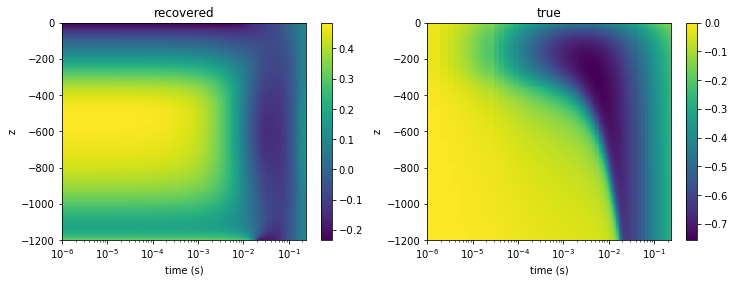

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(ax[0].pcolormesh(sim.times, z, mrec.reshape((len(z), sim.nT+1), order="F")), ax=ax[0])
ax[0].set_title("recovered")

plt.colorbar(ax[1].pcolormesh(sim.times, z, s0.reshape((len(z), sim.nT+1), order="F")), ax=ax[1])
ax[1].set_title("true")

for a in ax: 
    a.set_xscale("log")
    a.set_xlim(1e-6, sim.times.max())
    a.set_xlabel("time (s)")
    a.set_ylabel("z")

In [96]:
j_pred = mysim.fields(mrec)
j_true = mysim.fields(s0)

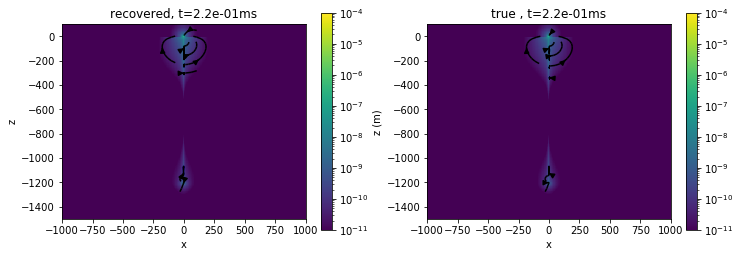

In [97]:
tind = 40
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

xlim = np.r_[-1000, 1000]
zlim = np.r_[-1500, 100]
sample_grid = np.r_[5., 5.]
clim = np.r_[1e-11, 1e-4]

out = mesh.plotImage(
    mesh.aveF2CCV * j_pred[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax[0], mirror=True,
    range_x=xlim, 
    range_y=zlim,
    sample_grid = sample_grid,
    pcolorOpts={"norm":LogNorm()},
    clim=clim, 
    stream_threshold=clim.min()
)

plt.colorbar(out[0], ax=ax[0])

ax[0].set_title(f"recovered, t={sim.times[tind]*1e3:1.1e}ms")


out2 = mesh.plotImage(
    mesh.aveF2CCV * j_true[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax[1], mirror=True,
    range_x=xlim, 
    range_y=zlim,
    sample_grid = sample_grid,
    pcolorOpts={"norm":LogNorm()},
    clim=clim, 
    stream_threshold=clim.min()
)
plt.colorbar(out2[0], ax=ax[1])
# ax[1].set_ylim(np.r_[-max_depth, top])
ax[1].set_ylabel('z (m)')
ax[1].set_title(f"true , t={sim.times[tind]*1e3:1.1e}ms")

for a in ax:
    a.set_aspect(1)

# invert the simulated data

In [98]:
model_dict, fields_dict, sim3D, mesh3D = load_trial(trial_directory)

casing
approx_casing


In [99]:
jd_3D = fields_dict["casing"][:, "j", :] - fields_dict["approx_casing"][:, "j", :]

In [100]:
jd_x = (jd_3D[:mesh3D.nFx, :]).reshape(np.hstack([mesh3D.vnFx, np.r_[sim.nT+1]]), order="F")
jd_z = (jd_3D[mesh3D.vnF[:2].sum():, :]).reshape(np.hstack([mesh3D.vnFz, np.r_[sim.nT+1]]), order="F")

# grab a slice through theta
theta_ind = 3
jd = np.hstack([
    discretize.utils.mkvc(jd_x[:, theta_ind, :, :]),
    discretize.utils.mkvc(jd_z[:, theta_ind, :, :]),
])

jd_obs = jd[j_inds]

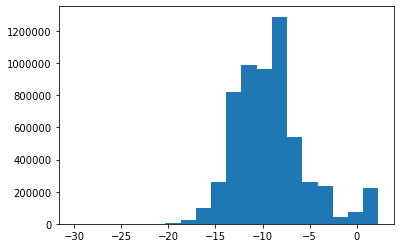

In [101]:
plt.hist(np.log10(np.abs(jd+1e-30)), 20);

In [102]:
model_halfspace = model.copy()
model_halfspace.sigma_casing = model.sigma_back
model_halfspace.sigma_inside = model.sigma_back

In [135]:
std = 0.05
floor = 1e-9
mysurvey = survey.BaseSurvey()
mysurvey._vnD = np.r_[len(jd_obs)]

# sigma = model.sigma_air * np.ones(mesh.nC)
# sigma[mesh.gridCC[:, 2] <0] = model.sigma_back
mysim.sigma = model.sigma(mesh)
mysim.survey = mysurvey
mydata2 = data.Data(mysurvey, dobs=jd_obs, standard_deviation=std, noise_floor=floor)


In [136]:
np.unique(mysim.sigma)

array([1.00000000e-04, 1.47910839e-02, 3.35012694e+06])

In [186]:
dmis = data_misfit.L2DataMisfit(data=mydata2, simulation=mysim)

reg = regularization.Tikhonov(
    mesh=reg_mesh, 
    alpha_x=dz.mean()**2, # space
    alpha_y=dt.mean()**2/100, # time
)

In [188]:
opt = optimization.InexactGaussNewton(maxIter=50)
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)

directiveslist = [
    directives.BetaEstimate_ByEig(beta0_ratio=1e2),
    directives.BetaSchedule(coolingFactor=4.),
    directives.TargetMisfit(),
    directives.SaveOutputDictEveryIteration(),
]

inv = inversion.BaseInversion(invprob, directiveList=directiveslist)

In [189]:
print(f"{mysurvey.nD:1.2e}, {0.5*mysurvey.nD:1.2e}")

1.42e+06, 7.09e+05


In [190]:
# m0 = np.zeros_like(s0)
srec = inv.run(srec)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/lindseyjh/git/python_symlinks/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2020-01-18-16-02.npz'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.49e+05  7.64e+06  2.13e+01  1.08e+07    5.16e+04      0              
   1  1.49e+05  7.65e+06  2.09e+01  1.07e+07    3.50e+04      0              
   2  1.49e+05  7.63e+06  2.07e+01  1.07e+07    2.35e+04      0              
   3  3.72e+04  7.89e+06  1.66e+01  8.51e+06    6.94e+04      0              
   4  3.72e+04  7.65e+06  1.67e+01  8.27e+06    2.53e+04      0              
   5  3.72e+04  7.67e+06  1.48e+01  8.23e+06    7.31e+04      0              
   6  9.30e+03  7.67e+06  1.35e+01  7.79e+06    3.32e+04      0              
   7  9.30e+03  7.65e+06  1.51e+01  7.79e+06    3.21e

# todo: look at the regularization 

In [175]:
reg.objfcts

In [179]:
for multiplier, fct in zip(reg.multipliers, reg.objfcts):
    print(f"{fct.__class__.__name__}: {multiplier * fct(srec)}")

Small: 0.0203510061067188
SmoothDeriv: 10.498041122693486
SmoothDeriv2: 0.0
SmoothDeriv: 1078.9911536305294
SmoothDeriv2: 0.0


Text(0, 0.5, 'z')

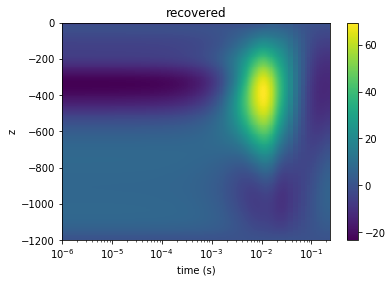

In [180]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.pcolormesh(sim.times, z, srec.reshape((len(z), sim.nT+1), order="F")), ax=ax)
ax.set_title("recovered")

ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

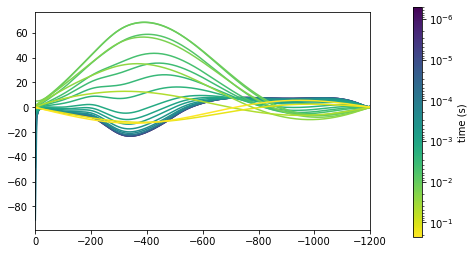

In [181]:
fig, ax = plt.subplots(1, 1)

cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=sim.time_mesh.vectorCCx[0], vmax=sim.time_mesh.vectorCCx[-1])
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plotme = srec.reshape((len(z), sim.nT+1), order="F")

for time_ind in range(sim.nT)[::int(sim.nT/20)]:
    color = scalar_map.to_rgba(sim.time_mesh.vectorCCx[time_ind])
    ax.plot(z, plotme[:, time_ind], color=color)

ax.set_xlim(z.max(), z.min())

cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cb = plt.colorbar(scalar_map, cbar_ax)
cb.set_label('time (s)')
cb.ax.invert_yaxis()

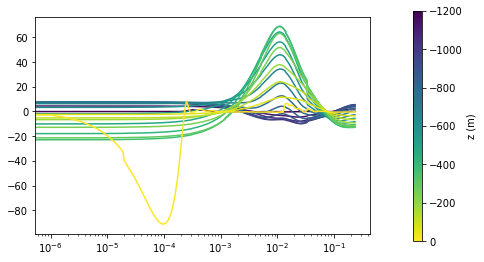

In [182]:
fig, ax = plt.subplots(1, 1)

cm = plt.get_cmap('viridis')
c_norm = Normalize(vmin=z.min(), vmax=z.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

plotme = srec.reshape((len(z), sim.nT+1), order="F")

for z_ind in range(len(z))[::int(len(z)/20)]:
    color = scalar_map.to_rgba(z[z_ind])
    ax.semilogx(sim.time_mesh.vectorNx, plotme[z_ind, :], color=color)

# ax.set_xlim(z.max(), z.min())

cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cb = plt.colorbar(scalar_map, cbar_ax)
cb.set_label('z (m)')
cb.ax.invert_yaxis()

In [183]:
j_rec = mysim.fields(srec)

/Users/lindseyjh/git/python_symlinks/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


In [184]:
model_names = list(model_dict.keys())
# sim.survey.source_list = sim.survey.source_list
viewer = casing_sim.FieldsViewer(
    mesh=mesh3D, model_parameters_dict=model_dict, survey_dict={key: sim3D.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

/Users/lindseyjh/git/python_symlinks/casingSimulations/view.py:536: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cb.set_clim(clim)


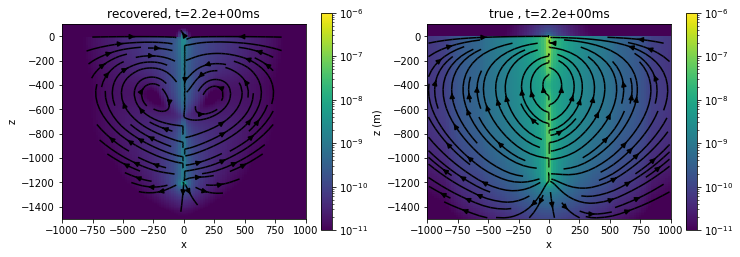

In [185]:
tind = 90
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

xlim = 1000*np.r_[-1, 1]
zlim = np.r_[-1500, 100]
sample_grid = np.r_[xlim.max()/50, 5.]
clim = np.r_[1e-11, 1e-6]

out = mesh.plotImage(
    mesh.aveF2CCV * j_rec[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax[0], mirror=True,
    range_x=xlim, 
    range_y=zlim,
    sample_grid = sample_grid,
    pcolorOpts={"norm":LogNorm()},
    clim=clim, 
    stream_threshold=clim.min()
)

plt.colorbar(out[0], ax=ax[0])

ax[0].set_title(f"recovered, t={sim.times[tind]*1e3:1.1e}ms")


out2 = viewer.plot_cross_section(
    ax=ax[1], clim=clim, zlim=zlim,
    xlim=xlim,
    view='j', theta_ind=3, time_ind=tind, 
    model_key='approx_casing', show_cb=True, casing_outline=False,
    prim_sec="secondary"
#     stream_opts={"density":0.75, "color": "k", "arrowsize": 2}
)
# ax[1].set_ylim(np.r_[-max_depth, top])
ax[1].set_ylabel('z (m)')
ax[1].set_title(f"true , t={sim.times[tind]*1e3:1.1e}ms")

for a in ax:
    a.set_aspect(1)

In [ ]:
viewer.widget_cross_section()

In [ ]:
mesh3D

In [ ]:
def compute_sm(tind, key="approx_casing", primary_key="casing"):
    j_diff = fields_dict[primary_key][:, 'j', tind] - fields_dict[key][:, 'j', tind]
    ja = fields_dict[key][:, 'j', tind]
    
    C = mesh3D.edgeCurl
    MfRhod = (
        mesh3D.getFaceInnerProduct(1./model_dict[primary_key].sigma(mesh3D) - 1./model_dict[key].sigma(mesh3D)) 
    )
    
    return - C.T * MfRhod * (ja + jd)

In [ ]:
# def compute_sm_error(tind, key="approx_casing", primary_key="casing", separate=False):
#     j_diff =  fields_dict[key][:, 'j', tind] - fields_dict[primary_key][:, 'j', tind]
#     dhdt_diff = fields_dict[key][:, 'dhdt', tind] - fields_dict[primary_key][:, 'dhdt', tind]
    
#     C = mesh3D.edgeCurl
#     MfRho = mesh3D.getFaceInnerProduct(1./model_dict[key].sigma(mesh3D))
#     MeMu = mesh3D.getEdgeInnerProduct(model_dict[key].mur(mesh3D)*mu_0)
    
#     if separate is True:
#         return (C.T * MfRho * j_diff, MeMu * dhdt_diff)
#     return C.T * MfRho * j_diff + MeMu * dhdt_diff

In [ ]:
def theta_index_mirror(theta_ind):
    return (
        theta_ind+int(mesh3D.vnC[1]/2)
        if theta_ind < int(mesh3D.vnC[1]/2)
        else theta_ind-int(mesh3D.vnC[1]/2)
    )

In [ ]:
def plot_sm_error(tind, theta_ind=0, key="approx_casing", primary_key="casing", ax=None, clim=None, xlim=None, zlim=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    plotme = compute_sm_error(tind, key, primary_key)

    if len(mesh.hy) == 1:
        plotme = mesh3D.aveE2CC * plotme
    else:
        plotme = (mesh3D.aveE2CCV * plotme)[mesh3D.nC:2*mesh3D.nC]
    
    theta_ind_mirror = theta_index_mirror(theta_ind)
    plotme = plotme.reshape(mesh3D.vnC, order="F")
    mirror_data = discretize.utils.mkvc(-plotme[:, theta_ind_mirror, :])
    plotme = discretize.utils.mkvc(plotme[:, theta_ind, :])

    norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))])
    )
    clim = clim[1]*np.r_[-1., 1.] if clim is not None else None
    
    mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)
    
    out = mesh2D.plotImage(
        plotme, ax=ax, pcolorOpts = {'norm': norm, "cmap": "BrBG_r"}, clim=clim,
        mirror_data=mirror_data, mirror=True
    )

    cb = plt.colorbar(out[0], ax=ax)
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    


In [ ]:
def widget_sm(tind, theta_ind, clim_min, clim_max):
    fig, ax = plt.subplots(1, 1, figsize=(4, 6))
    plot_sm_error(
        tind=tind, theta_ind=theta_ind, ax=ax, xlim=0.15*np.r_[-1, 1], zlim=[-1.1*model_dict["casing"].casing_l, 10],
        clim=np.r_[clim_min, clim_max],
    )

ipywidgets.interact(
    widget_sm, 
    tind = ipywidgets.IntSlider(min=0, max=sim.nT+1, value=0),
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh3D.hy), value=3),
    clim_min = ipywidgets.FloatText(value=1e-6),
    clim_max = ipywidgets.FloatText(value=1e-4),
#     term = ipywidgets.ToggleButtons(options=[0, 1, 2], value=2)
)

In [ ]:
sm = discretize.utils.mkvc(compute_sm_error(tind=40, key="approx_casing", primary_key="casing"))
smx = sm[:mesh3D.vnE[0]]
smy = sm[mesh3D.vnE[0]:mesh3D.vnE[:2].sum()]
smz = sm[mesh3D.vnE[:2].sum():]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ylim = np.r_[1e-7, 1e-3]

for a, s, title in zip(ax, [smx, smy, smz], ["x", "y", "z"]):
    a.semilogy(np.abs(s))
    a.set_title(title)
    a.set_ylim(ylim)

In [ ]:
inds = np.abs(smy) > 1e-6

In [ ]:
source_grid = mesh3D.gridEy[inds, :]

In [ ]:
np.unique(source_grid[:, 0])

In [ ]:
SMY = []

for t in range(sim.nT+1):
    smi = discretize.utils.mkvc(compute_sm_error(tind=t, key="approx_casing", primary_key="casing"))
    smyi = discretize.utils.mkvc(smi[mesh3D.vnE[0]:mesh3D.vnE[:2].sum()])
    SMY.append(smyi)

In [ ]:
SMY = np.vstack(SMY).T

In [ ]:
radii = np.r_[0.02, 0.025, 0.03, 0.035, 0.04]
eps = 1e-3
smy_casing = []

for r in radii: 
    inds = (
        (mesh3D.gridEy[:, 0] >= r-eps) & (mesh3D.gridEy[:, 0] <= r+eps) &
        (mesh3D.gridEy[:, 1] == mesh3D.vectorCCy[3]) & 
        (mesh3D.gridEy[:, 2] >= -model.casing_l) & (mesh3D.gridEy[:, 2] <= 0)
    )
    smy_casing.append(SMY[inds, :])


In [ ]:
smy_casing[0].shape

In [ ]:
fig, ax = plt.subplots(1, len(radii), figsize=(5*len(radii), 4))

for i in range(len(smy_casing)):
    plt.colorbar(
        ax[i].pcolormesh(sim.times, z, (smy_casing[i]).reshape((len(z), sim.nT+1), order="F")), 
        ax=ax[i]
    )
    ax[i].set_title(f"r = {radii[i]}")

for a in ax: 
    a.set_xscale("log")
    a.set_xlim(1e-6, sim.times.max())
    a.set_xlabel("time (s)")
    a.set_ylabel("z")
plt.tight_layout()

In [ ]:
tind = 50
fig, ax = plt.subplots(1, 1) 

for i in range(len(smy_casing)):
    ax.plot(z, smy_casing[i][:, tind], label=f"r = {radii[i]}")
    
ax.legend()
ax.ticklabel_format(axis="y", scilimits=(0, 0))
ax.set_title(f"time {1e3*sim.times[tind]:1.1e}ms")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel("z (m)")

## run a forward simulation with primary-secondary source

In [ ]:
src_inds2 = (
    (mesh.gridEy[:, 0] >= 0) & (mesh.gridEy[:, 0] <= radii.max()+eps) & 
    (mesh.gridEy[:, 2] >= -model.casing_l) & (mesh.gridEy[:, 2] <= 0)
)
src_inds2 = np.ones(mesh.nE, dtype=bool)

src_map2 = SourceMap(mesh, np.where(src_inds2)[0], sim.nT+1)

In [ ]:
sigma = model.sigma_air * np.ones(mesh.nC)
sigma[mesh.gridCC[:, 2] < 0] = model.sigma_back

In [ ]:
mysim_sm = MySimulation(
    mesh=mesh, time_steps=sim3D.time_steps, 
    solver=Solver, solver_opts=solver_opts, sigma=sigma, #sigma=model.sigma(mesh),
    source_map=src_map2, j_inds=j_inds
)

In [ ]:
jd_x = (jd_3D[:mesh3D.nFx, :]).reshape(np.hstack([mesh3D.vnFx, np.r_[sim.nT+1]]), order="F")
jd_z = (jd_3D[mesh3D.vnF[:2].sum():, :]).reshape(np.hstack([mesh3D.vnFz, np.r_[sim.nT+1]]), order="F")

# grab a slice through theta
theta_ind = 3
jd = np.hstack([
    discretize.utils.mkvc(jd_x[:, theta_ind, :, 0]),
    discretize.utils.mkvc(jd_z[:, theta_ind, :, 0]),
])

In [ ]:
jd.shape

In [ ]:
src_inds3D = (
#     (mesh3D.gridEy[:, 0] >= 0) & (mesh3D.gridEy[:, 0] <= radii.max()+eps) &
    (mesh3D.gridEy[:, 1] == mesh3D.vectorCCy[3]) 
#     (mesh3D.gridEy[:, 2] >= -model.casing_l) & (mesh3D.gridEy[:, 2] <= 0)
)
smy3D = discretize.utils.mkvc(SMY[src_inds3D, :])

In [ ]:
j_sm = mysim_sm.fields(smy3D, j0=discretize.utils.mkvc(jd))

In [ ]:
tind = 40
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

xlim = 1000*np.r_[-1, 1]
zlim = np.r_[-1500, 100]
sample_grid = np.r_[xlim.max()/50, 5.]
clim = np.r_[1e-12, 1e-6]

out = mesh.plotImage(
    mesh.aveF2CCV * j_sm[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax[0], mirror=True,
    range_x=xlim, 
    range_y=zlim,
    sample_grid = sample_grid,
    pcolorOpts={"norm":LogNorm()},
    clim=clim, 
    stream_threshold=clim.min()
)

plt.colorbar(out[0], ax=ax[0])

ax[0].set_title(f"estimated, t={sim.times[tind]*1e3:1.1e}ms")

out2 = viewer.plot_cross_section(
    ax=ax[1], clim=clim, zlim=zlim,
    xlim=xlim,
    view='j', theta_ind=3, time_ind=tind, 
    model_key='approx_casing', show_cb=True, casing_outline=False,
    prim_sec="secondary"
#     stream_opts={"density":0.75, "color": "k", "arrowsize": 2}
)
# ax[1].set_ylim(np.r_[-max_depth, top])
ax[1].set_ylabel('z (m)')
ax[1].set_title(f"true , t={sim.times[tind]*1e3:1.1e}ms")

# for a in ax:
#     a.set_aspect(1)